https://tartarus.org/martin/PorterStemmer/def.txt



https://tartarus.org/martin/PorterStemmer/




# Spam Classifier in Python

We all face the problem of spams in our inboxes. Let’s build a spam classifier program in python which can tell whether a given message is spam or not! We can do this by using a simple, yet powerful theorem from probability theory called Baye’s Theorem. It is mathematically expressed as

Problem Statement
We have a message m = (w1, w2, . . . . , wn), where (w1, w2, . . . . , wn) is a set of unique words contained in the message. We need to find


If we assume that occurrence of a word are independent of all other words, we can simplify the above expression to


In order to classify we have to determine which is greater

# 1. Loading dependencies

In [52]:
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import string
%matplotlib inline  
def ok():
    print('ok')

In [53]:
mails = pd.read_csv('mail_data.csv')
mails 
mails.rename(columns={'Message':'message'},inplace = True)

In [54]:
mails['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [55]:
mails['label'] = mails['Category'].map({'ham': 0, 'spam': 1})
mails.head()

Category                                            message  label
0      ham  Go until jurong point, crazy.. Available only ...      0
1      ham                      Ok lar... Joking wif u oni...      0
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...      1
3      ham  U dun say so early hor... U c already then say...      0
4      ham  Nah I don't think he goes to usf, he lives aro...      0

In [56]:
mails.drop(['Category'], axis = 1, inplace = True)
mails.head()

message  label
0  Go until jurong point, crazy.. Available only ...      0
1                      Ok lar... Joking wif u oni...      0
2  Free entry in 2 a wkly comp to win FA Cup fina...      1
3  U dun say so early hor... U c already then say...      0
4  Nah I don't think he goes to usf, he lives aro...      0

In [57]:
print(mails.shape[0])
ok()

5572
ok


In [58]:
totalMails = 5572
trainIndex, testIndex = list(), list()
for i in range(5156):
    if np.random.uniform(0, 1) < 0.75:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = mails.loc[trainIndex]
testData = mails.loc[testIndex]
ok()

ok


In [59]:
nltk.download('stopwords')
def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    clean_word = [word for word in nopunc.split() if word.lower() not in stopwords('english')]


    return clean_word
ok()

ok


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [60]:
trainData.reset_index(inplace = True)
trainData.drop(['index'], axis = 1, inplace = True)
trainData.head()

message  label
0  FreeMsg Hey there darling it's been 3 week's n...      1
1  As per your request 'Melle Melle (Oru Minnamin...      0
2  WINNER!! As a valued network customer you have...      1
3  Had your mobile 11 months or more? U R entitle...      1
4  I'm gonna be home soon and i don't want to tal...      0

In [61]:
trainData['label'].value_counts()

0    3270
1     520
Name: label, dtype: int64

In [62]:
testData['label'].value_counts()

0    1188
1     178
Name: label, dtype: int64

# Visualizing data

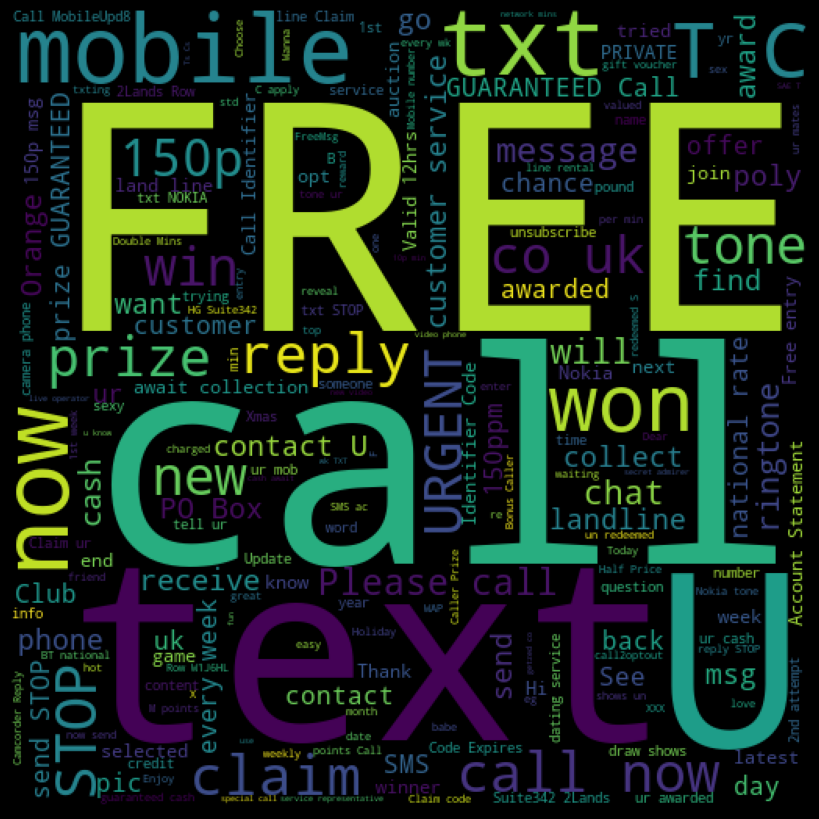

In [63]:
spam_words = ' '.join(list(mails[mails['label'] == 1]['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

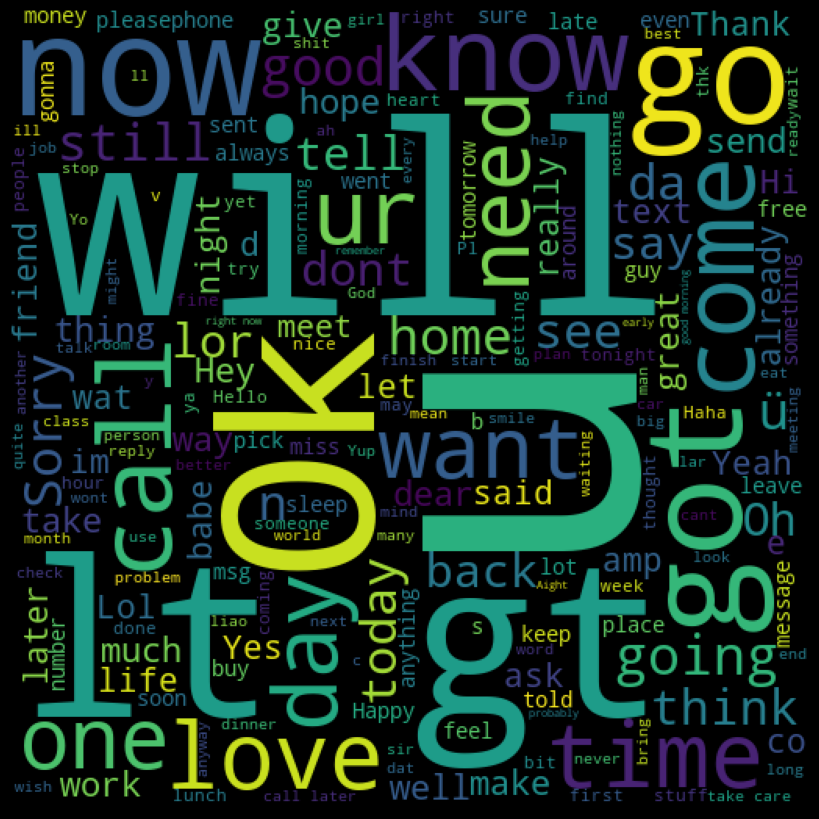

In [64]:
ham_words = ' '.join(list(mails[mails['label'] == 0]['message']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [65]:
testData.reset_index(inplace = True)
testData.drop(['index'], axis = 1, inplace = True)
testData.head()

message  label
0  Go until jurong point, crazy.. Available only ...      0
1                      Ok lar... Joking wif u oni...      0
2  Free entry in 2 a wkly comp to win FA Cup fina...      1
3  U dun say so early hor... U c already then say...      0
4  Nah I don't think he goes to usf, he lives aro...      0

# Training the model

In [66]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words =message.split()
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words
ok()

ok


In [67]:
def uxaki(gram = 2):
    if gram > 1 :
        return 5
    return 6
a = uxaki(1)
a


6

In [68]:
class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.mails, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails /  \
             self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.mails[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails)  / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails)  / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result
ok()

ok


In [69]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)
ok()

ok


# Final result

In [70]:

sc_tf_idf = SpamClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)

Precision:  0.8962962962962963
Recall:  0.6797752808988764
F-score:  0.7731629392971245
Accuracy:  0.9480234260614934


In [71]:
sc_bow = SpamClassifier(trainData, 'bw')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])
metrics(testData['label'], preds_bow)

Precision:  0.9009009009009009
Recall:  0.5617977528089888
F-score:  0.6920415224913494
Accuracy:  0.9348462664714495


In [72]:
pm = process_message('I cant pick the phone right now. Pls send a message')
sc_tf_idf.classify(pm)

False

In [73]:
pm = process_message('Congratulations ur awarded $500 ')
sc_tf_idf.classify(pm)

True